# Graph nodes position

Calculation of different possible node layouts, to be used in all the other scripts to have a uniform node positions for the same graph in different files. The best position is calculated in a way that representation for the most of the layers is "clustered".

In [1]:
# Basic math libraries
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
import pickle
from matplotlib.colors import ListedColormap

# Matrix eigendecomposition
import numpy.linalg as lg
import scipy.linalg as slg

# Networks and Graphs
import networkx as nx
import dynetx as dn
import graphviz 
from networkx.drawing.nx_agraph import graphviz_layout

# Random data generation
import itertools
import random
from collections import Counter
from random import randint
from itertools import chain

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

%load_ext autoreload
%autoreload 2
import time

## Retrieve active nodes of the hospital-workplace-school layers

In [2]:
# function to build a graph given a laplacian matrix

def graph_from_laplacian(L):
    A = -L
    np.fill_diagonal(A, 0)
    A_ = np.maximum(A, 0)
    G = nx.from_numpy_matrix(A_)
    return G


# function to draw a network with weighted edges

def show_network(G, weighted=False, pos=None, ax=None, figsize=(5,5), node_color='b'):
    if ax is None:
        plt.figure(figsize=figsize)
        plt.axis('off')
        ax = plt.gca()
    if pos is None:
        pos = nx.spring_layout(G) 
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = tuple(w*10 for w in weights)     # maybe useless
    emap = plt.cm.Greys if weighted else ListedColormap([(0,0,0)])
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color, ax=ax) # cmap=MyCmap,
    nx.draw_networkx_edges(G, pos, width=0.5, edgelist=edges, edge_color=weights, edge_cmap=emap, ax=ax) #alpha=2, ax=ax)

In [3]:
# Import the multilayer dynamic network from file, to avoid recreating it every time

L = np.load("datasets/outputs/multilayer_dynamic_network.npy", allow_pickle=True)
L = [[L[t][s] for s in range(len(L[0]))] for t in range(len(L))]
N = len(L[0][0])

In [4]:
# calc hospital nodes
# first slot
L_hospital_nodes = L[0][0] + L[1][0] + L[2][0] + L[3][0]
G_hospital_nodes = graph_from_laplacian(L_hospital_nodes)
G_hospital_nodes.remove_nodes_from(list(nx.isolates(G_hospital_nodes)))
a = G_hospital_nodes.nodes()
#second slot
L_hospital_nodes = L[4][0] + L[5][0] + L[6][0] + L[7][0]
G_hospital_nodes = graph_from_laplacian(L_hospital_nodes)
G_hospital_nodes.remove_nodes_from(list(nx.isolates(G_hospital_nodes)))
b = G_hospital_nodes.nodes()
hospital_nodes = sorted( list(set(a) & set(b)) )
print("\n\nhospital_nodes:\n", hospital_nodes)


# calc workplace nodes
L_workplace_nodes = L[0][1] + L[1][1] + L[2][1] + L[3][1] + L[4][1] + L[5][1] + L[6][1] 
G_workplace_nodes = graph_from_laplacian(L_workplace_nodes)
G_workplace_nodes.remove_nodes_from(list(nx.isolates(G_workplace_nodes)))
workplace_nodes = sorted(G_workplace_nodes.nodes())
print("\n\nworkplace_nodes:\n", workplace_nodes)


# calc school nodes 
L_school_nodes = L[0][3]
G_school_nodes = graph_from_laplacian(L_school_nodes)
G_school_nodes.remove_nodes_from(list(nx.isolates(G_school_nodes)))
school_nodes = sorted(G_school_nodes.nodes())
print("\n\nschool_nodes:\n", school_nodes)


print("\n\n\nNODES INTERVALS:")
print("hospital_nodes: lenght", len(hospital_nodes), ", indices from", min(hospital_nodes), "indices to", max(hospital_nodes), ", covering a range of n. nodes", max(hospital_nodes)-min(hospital_nodes) )
print("workplace_nodes: lenght", len(workplace_nodes), ", indices from", min(workplace_nodes), "indices to", max(workplace_nodes), ", covering a range of n. nodes", max(workplace_nodes)-min(workplace_nodes) )
print("hospital_nodes: lenght", len(school_nodes), ", indices from", min(school_nodes), "indices to", max(school_nodes), ", covering a range of n. nodes", max(school_nodes)-min(school_nodes) )




hospital_nodes:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 49, 52, 61, 62, 63, 65, 66, 67, 68, 69, 70, 73]


workplace_nodes:
 [71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162]


school_nodes:
 [255, 256, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,

## Creation of the position layout and file saving
Run only once to calculate the preferred layout - node position (heavy calculation) and save it in a file "datasets/inputs/position_network.npy" that is taken into account for the followign running. For the first time calculation, let the notebook run with pos= None. Once the result is saved, put back the definition of pos taken from the file, and run again.

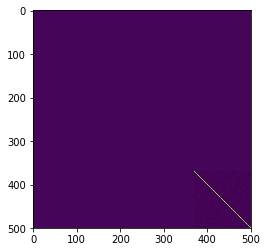

In [5]:
# for graphic purposes only, create a Laplacian for the isolated points so that they are all close together (bool SB; with 1 class only)


missing_size = N - max(school_nodes)
blocks = [missing_size]
probs = [[0.5]]
gt = nx.stochastic_block_model(blocks, probs, seed = 100)
lt = nx.laplacian_matrix(gt,range(len(gt)))
lt = np.array(lt.todense()) 

L_isolates = scipy.linalg.block_diag(np.zeros((N-missing_size, N-missing_size), dtype='int32'), lt)
plt.imshow(L_isolates)

In [6]:
# create a representative cluster global laplacian summing up the main clustered layers and the remained cluster of isolated nodes

L_pos = L_hospital_nodes + L_workplace_nodes + L_school_nodes + L_isolates
graph_to_display = nx.from_numpy_matrix(-L_pos + np.diag(np.diag(L_pos)))

GRAPHVIZ POSSIBLE LAYOUTS

1. dot - "hierarchical" or layered drawings of directed graphs. This is the default tool to use if edges have directionality.

2. neato - "spring model'' layouts. This is the default tool to use if the graph is not too large (about 100 nodes) and you don't know anything else about it. Neato attempts to minimize a global energy function, which is equivalent to statistical multi-dimensional scaling.

3. fdp - "spring model'' layouts similar to those of neato, but does this by reducing forces rather than working with energy.

4. sfdp - multiscale version of fdp for the layout of large graphs.

5. twopi - radial layouts, after Graham Wills 97. Nodes are placed on concentric circles depending their distance from a given root node.

6. circo - circular layout, after Six and Tollis 99, Kauffman and Wiese 02. This is suitable for certain diagrams of multiple cyclic structures, such as certain telecommunications networks.

Thu Mar 18 14:57:33 2021 pos creation:
Thu Mar 18 14:57:36 2021
Thu Mar 18 14:57:36 2021 graph plotting:
Thu Mar 18 14:57:36 2021


/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


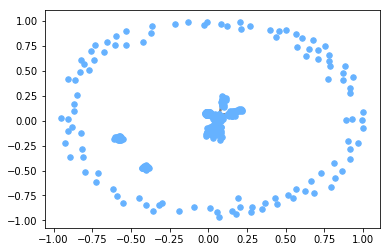

In [7]:
# CASE 0: SPRING LAYOUT


print( time.ctime(), "pos creation:")
pos_0=nx.spring_layout(graph_to_display)
print( time.ctime())
   
    
print( time.ctime(), "graph plotting:")    
nx.draw_networkx_nodes(graph_to_display, pos=pos_0, node_size=30, node_color='#66B2FF')
nx.draw_networkx_edges(graph_to_display, pos=pos_0, width=0.5, edge_color='grey')
print(time.ctime())

Thu Mar 18 14:57:37 2021 pos creation:
Thu Mar 18 14:57:42 2021
Thu Mar 18 14:57:42 2021 graph plotting:
Thu Mar 18 14:57:42 2021


/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


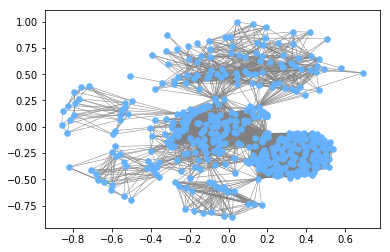

In [8]:
# CASE 1: KAMADA KAWAI


print( time.ctime(), "pos creation:")
pos_1=nx.kamada_kawai_layout(graph_to_display)
print( time.ctime())
   
    
print( time.ctime(), "graph plotting:")    
nx.draw_networkx_nodes(graph_to_display, pos=pos_1, node_size=30, node_color='#66B2FF')
nx.draw_networkx_edges(graph_to_display, pos=pos_1, width=0.5, edge_color='grey')
print(time.ctime())

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


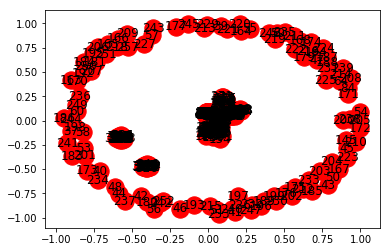

In [11]:
# TEST TO DELETE

# G = graph_from_laplacian(L_file[0][4])
nx.draw_networkx(graph_to_display, pos=pos_0)
# nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_color, ax=ax) # cmap=MyCmap,
# nx.draw_networkx_edges(G, pos, width=0.5, edgelist=edges, edge_color=weights, edge_cmap=emap, ax=ax) #alpha=2, ax=ax)

In [12]:
pos_to_import = pos_1
pos_name = "kamada_kawai"
np.save("datasets/nodes position for plot/position_network_" + pos_name + ".npy", pos_to_import)

## Experiments of importing pos
Check that the exported position can be easily imported and that effetively works to represent different layers in a similar structure

In [ ]:
# experiment
layout = "spring_layout"
pos_imported = np.load("datasets/nodes position for plot/position_network_" + layout + ".npy", allow_pickle=True).item()


# hospital
show_network(G_hospital_nodes, pos=pos_imported)

# workplace
show_network(G_workplace_nodes, pos=pos_imported)

# school
show_network(G_school_nodes, pos=pos_imported)

In [ ]:
L_agg = np.load("datasets/outputs/aggregated_dynamic_network.npy", allow_pickle=True)
L_agg = [np.matrix(l) for l in L_agg]
G_agg = [graph_from_laplacian(l) for l in L_agg]

for g in G_agg:
    nx.draw_networkx(g, pos=pos_imported)
    plt.show()